In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
try:
    import pycaret
except:
    !pip install pycaret

try:
    import missingno
except:
    !pip install missingno

ERROR: Could not find a version that satisfies the requirement pycaret (from versions: none)
ERROR: No matching distribution found for pycaret


<hr style="border: solid 3px blue;">

# Introduction





**Let's imagine you are a doctor. You have to diagnose the patient and determine if he has heart disease. In that case, two things will be very important:**

* If it is heart disease, it should not be judged as normal. An undiagnosed heart disease should not lead to an accident that prevents the patient from receiving appropriate treatment. In other words, **recall** becomes a very important metric.
* Diagnosis results should be well explained in a way that the patient can understand. In other words, you should be able to logically explain to the patient which features influenced your decision.

-----------------------------------------------------------------
## Features
* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

----------------------------------------------------
# Importing Libraries

In [3]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [4]:
def plot_histgram(feature):    
    fig = px.histogram(heart_df, x=feature,
                       color="HeartDisease", 
                       marginal="box",
                       barmode ="overlay",
                       histnorm ='density'
                      )  
    fig.update_layout(
        title_font_color="white",
        legend_title_font_color="yellow",
        title={
            'text': feature+" histogram",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        paper_bgcolor="black",
        plot_bgcolor='black',
        font_color="white"
    )
    fig.show()

<hr style="border: solid 3px blue;">

# EDA

In [5]:
heart_df = pd.read_csv("../input/heart-failure-prediction/heart.csv")
heart_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Age,40,49,37,48,54
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
RestingECG,Normal,Normal,ST,Normal,Normal
MaxHR,172,156,98,108,122
ExerciseAngina,N,N,N,Y,N
Oldpeak,0.000000,1.000000,0.000000,1.500000,0.000000


In [6]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


------------------------------------
# Checking Missing Values

<AxesSubplot:>

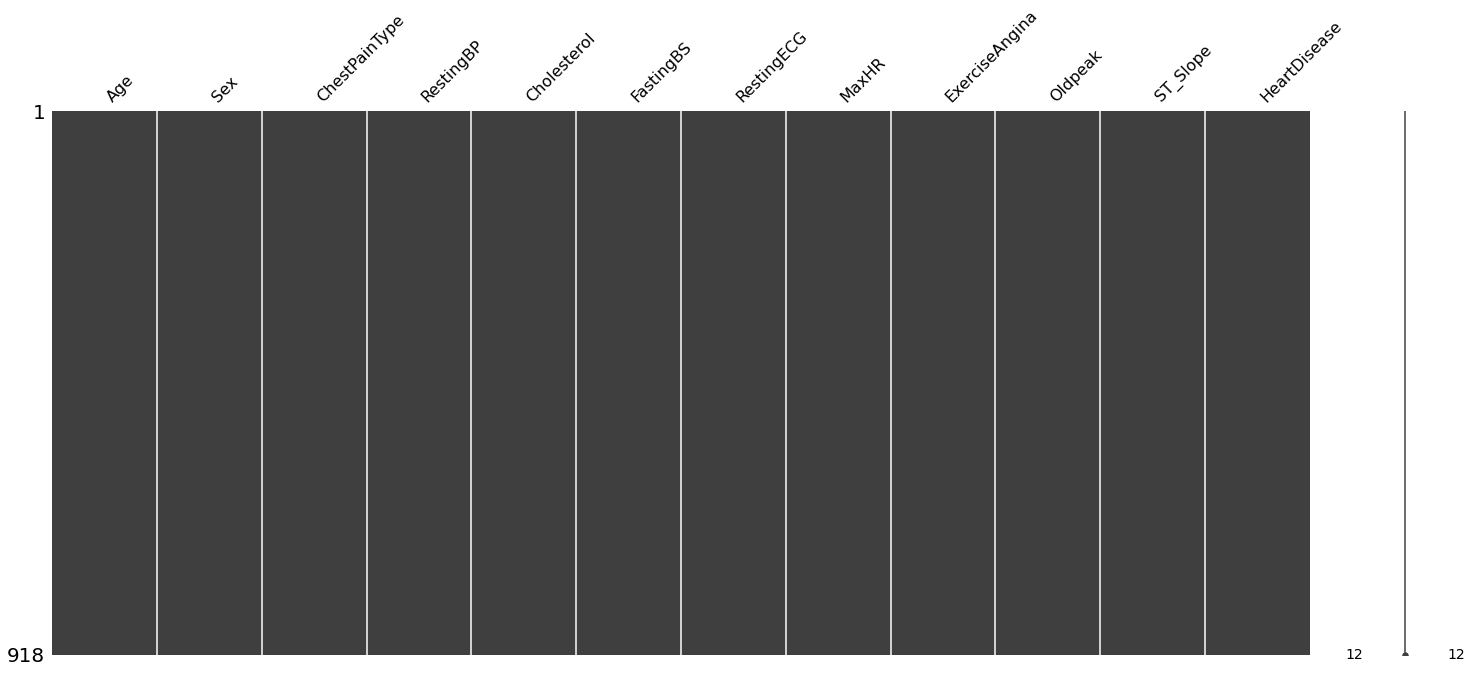

In [7]:
import missingno as msno
msno.matrix(heart_df)

<span style="color:Blue"> Observation:
    
**OK. There is no missing values!**

# Checking the data type of features

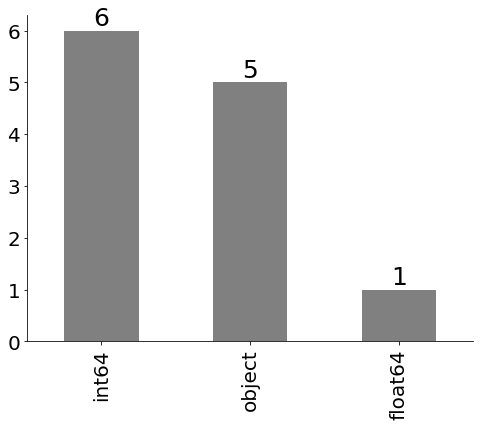

In [8]:
plt.figure(figsize = (8,6))
ax = heart_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 0.1, height, ha = 'center', size = 25)
sns.despine()

-------------------------------------------
# Checking Target Imbalance

In [9]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Heart Disease']
values = heart_df['HeartDisease'].value_counts()/heart_df['HeartDisease'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Heart Disease",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

<span style="color:Blue"> Observation:
    
**OK! Target is balanced!**

<hr style="border: solid 2px black;">

# Categorical Features



In [10]:
cat_cols = [cname for cname in heart_df.loc[:,:'ST_Slope'].columns if
                    heart_df[cname].dtype == "object"]

# Select numerical columns
int_cols = [cname for cname in heart_df.loc[:,:'ST_Slope'].columns if 
                heart_df[cname].dtype in ['int64']]
float_cols = [cname for cname in heart_df.loc[:,:'ST_Slope'].columns if 
                heart_df[cname].dtype in ['float64']]

num_cols = int_cols + float_cols

------------------------------------
## Sex 

The person's sex (1 = male, 0 = female)

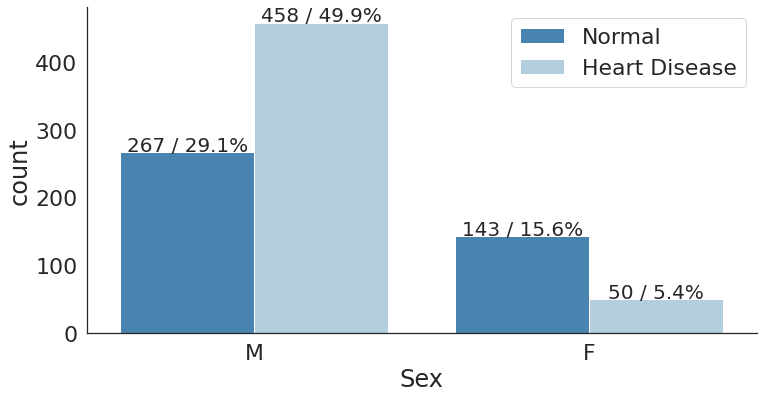

In [11]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='Sex',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* A man was diagnosed with a lot.
* Men were diagnosed with heart disease more than women. 

---------------------------------------------------
### ChestPainType ( Chest Pain Type )


The chest pain experienced 
* TA: typical angina 
* ATA: atypical angina 
* NAP: non-anginal pain
* ASY: asymptomatic

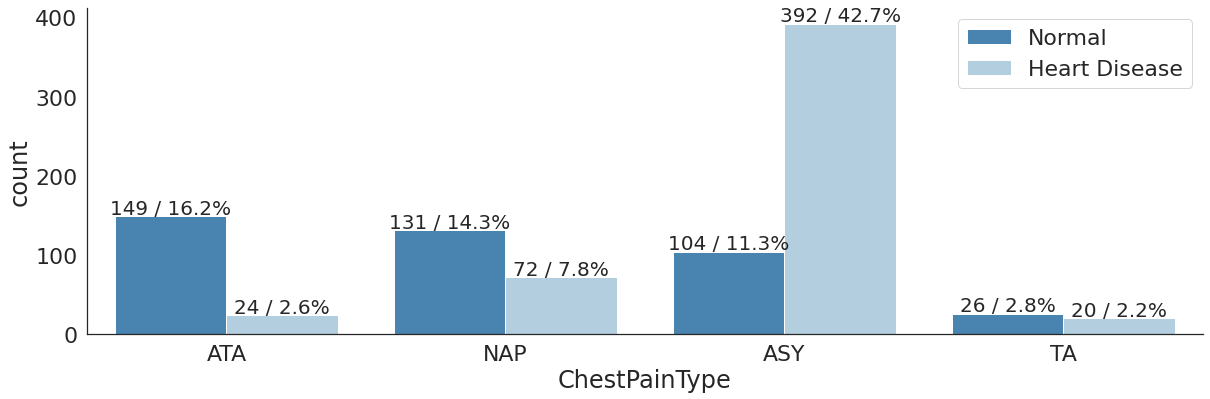

In [12]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(20,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='ChestPainType',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* Even asymptomatic patients are often diagnosed with heart disease!

-----------------------------------------------------------
## RestingECG ( resting electrocardiogram results )



Resting electrocardiographic measurement

* Normal: Normal, 
* ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 
* LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria

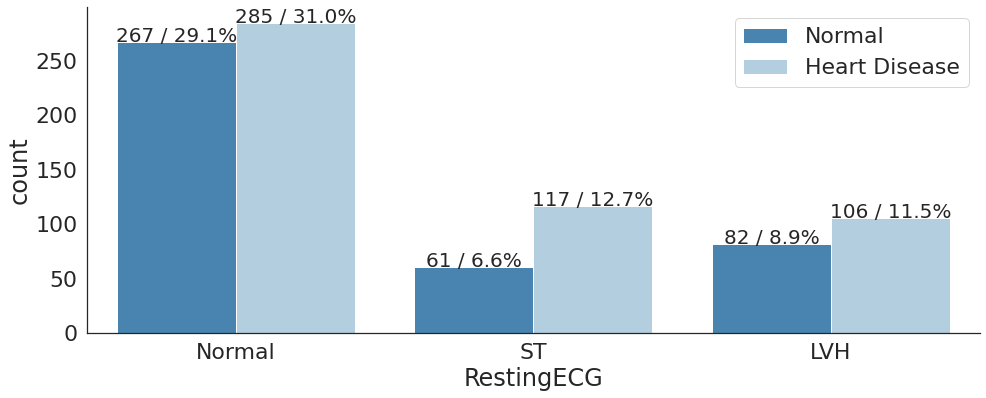

In [13]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(16,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='RestingECG',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 5, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

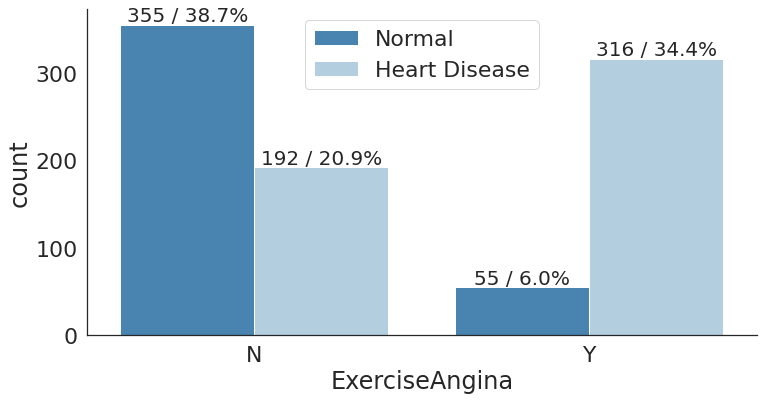

In [14]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='ExerciseAngina',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* Heart disease is often diagnosed when exercise-induced angina is present.

----------------------
## FastingBS
fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

![](https://bizimages.withfloats.com/actual/5cf01dd2a5a2e6000120f19f.jpg)

Picture Credit: https://bizimages.withfloats.com


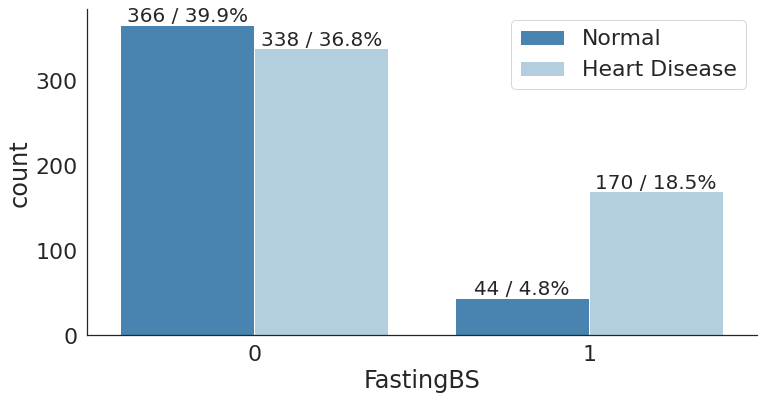

In [15]:
total_cnt = heart_df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=heart_df, x='FastingBS',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

<span style="color:Blue"> Observation:
* When ST_Slope is Up, it is often judged as Normal.
* If ST_Slope is flat/down, it is often judged as heart disease.

In [16]:
num_cols.remove("FastingBS")

In [17]:
def display_stat(feature):
    mean = heart_df[feature].mean()
    std = heart_df[feature].std()
    skew = heart_df[feature].skew()
    kurtosis = heart_df[feature].kurtosis()
    print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))

----------------------------------------------------
## Age

In [18]:
plot_histgram('Age')
display_stat('Age')

mean: 53.5109, std: 9.4326, skew: -0.1959, kurtosis: -0.3861 


<span style="color:Blue"> Observation:
* The median of the age of people judged for heart disease is 57 years old, which is larger than the median value of normal people.

## Handling outlier

Let's change the outlier to the median value.

In [19]:
heart_df['RestingBP'].replace(0, heart_df['RestingBP'].median(),inplace=True)

In [20]:
plot_histgram('RestingBP')
display_stat('RestingBP')

mean: 132.5381, std: 17.9901, skew: 0.6080, kurtosis: 0.7962 


<span style="color:Blue"> Observation:
    
Outliers have been removed, and skewness and kurtosis are also stable.

## Handling outlier

Let's change the outlier to the median value.

In [21]:
heart_df['Cholesterol'].replace(0, heart_df['Cholesterol'].median(),inplace=True)

In [22]:
plot_histgram('Cholesterol')
display_stat('Cholesterol')

mean: 240.5817, std: 53.9830, skew: 1.5374, kurtosis: 6.2441 


<span style="color:Blue"> Observation:
    
Outliers have been removed, and skewness and kurtosis are also stable.

---------------------------------------------------
## MaxHR ( maximum heart rate achieved [Numeric value between 60 and 202] )

![](https://i0.wp.com/www.healthyperformance.co.uk/wp-content/uploads/2020/02/max-heart-rate.png)

Picture Credit: https://i0.wp.com

In [23]:
plot_histgram('MaxHR')
display_stat('MaxHR')

mean: 136.8094, std: 25.4603, skew: -0.1444, kurtosis: -0.4482 
